In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from scipy import interp
import itertools
%matplotlib inline


Using TensorFlow backend.


In [2]:
df = pd.read_csv("creditcard.csv")

<a id='EDA'></a>

# Exploratory data analysis

In [3]:
table.isnull().sum().all()

False

Null elements are not present in the dataset.

In [4]:
table.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
table.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [7]:
table.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


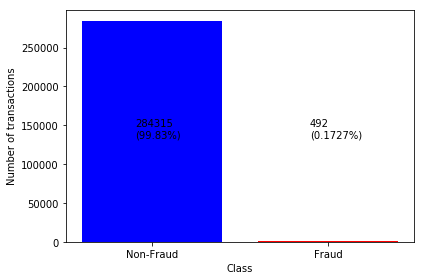

In [8]:
plt.bar(['Non-Fraud','Fraud'], table['Class'].value_counts(), color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}\n({:.4}%)'.format(table['Class'].value_counts()[0], 
                                         table['Class'].value_counts()[0]/table['Class'].count()*100),
             (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}\n({:.4}%)'.format(table['Class'].value_counts()[1], 
                                         table['Class'].value_counts()[1]/table['Class'].count()*100),
             (0.70, 0.45), xycoords='axes fraction')
plt.tight_layout()
plt.show()

The dataset has only two classes: fraud or non-fraud. The classes are highly imbalanced with 99.83% of observations belonging to non-fraudulent transactions and only 0.17% of observations labeled as fraudulent. This issue will be adressed later with a method for balancing classes.

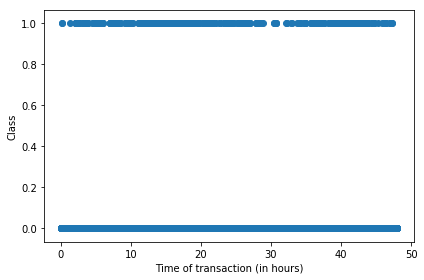

In [9]:
plt.scatter(table['Time']/(60*60), table['Class'])
plt.xlabel('Time of transaction (in hours)')
plt.ylabel('Class')

plt.tight_layout()
plt.show()

The data was collected over the period of 2 days and, apparently, the 'Time' variable isn't a good predictor for frauds. As seen above, the pattern for both non-fradulent and fraudulent transactions seems to be random regarding the hour of the day.

Number of outliers below the lower bound:  0  (0.0%)
Number of outliers above the upper bound:  31904  (11.2%)


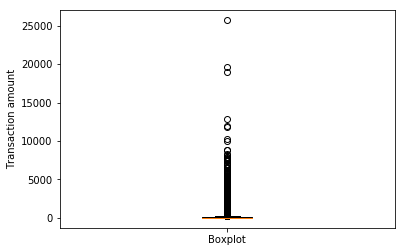

In [10]:
plt.boxplot(table['Amount'], labels = ['Boxplot'])
plt.ylabel('Transaction amount')
plt.plot()

amount = table[['Amount']].sort_values(by='Amount')
q1, q3 = np.percentile(amount,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

print('Number of outliers below the lower bound: ', amount[amount['Amount'] < lower_bound].count()[0],
     ' ({:.4}%)'.format(amount[amount['Amount'] < lower_bound].count()[0] / amount['Amount'].count() * 100))
print('Number of outliers above the upper bound: ', amount[amount['Amount'] > upper_bound].count()[0],
      ' ({:.4}%)'.format(amount[amount['Amount'] > upper_bound].count()[0] / amount['Amount'].count() * 100))

The interquartile range method found 31904 outliers, which represents 11.2% of the observations. Removing them from the dataset would be a bad idea due to the loss of a large amount of information for the machine learning models.

In [11]:
table[table['Class']==1].where(table['Amount']>upper_bound).count()['Amount']

91

In addition to that, only 91 out of 31904 outliers are classified as frauds.

The next two plots show that fraudulent transactions are highly concentrated at smaller values when compared to non-fraudulent transactions.

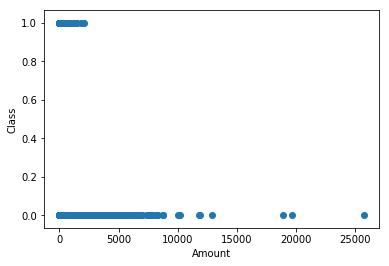

In [12]:
plt.scatter(table['Amount'], table['Class'])
plt.xlabel('Amount')
plt.ylabel('Class')
plt.show()

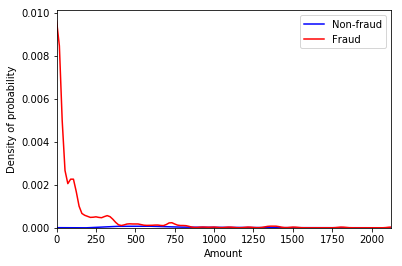

In [13]:
target_0 = table.loc[table['Class'] == 0]
target_1 = table.loc[table['Class'] == 1]
ax1=sns.distplot(target_0[['Amount']], hist=False, color='b', label='Non-fraud')
ax2=sns.distplot(target_1[['Amount']], hist=False, color='r', label='Fraud')
ax1.set_xlim(0, max(table[table['Class']==1]['Amount']))
ax2.set_xlim(0, max(table[table['Class']==1]['Amount']))
plt.legend()
plt.xlabel('Amount')
plt.ylabel('Density of probability')
plt.show()

In [14]:
table.loc[table['Class'] == 1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

We can see below that all features have very low correlation coefficients among each other, and especially low correlation with the 'Class' feature. This was already expected since the data was processed using PCA.

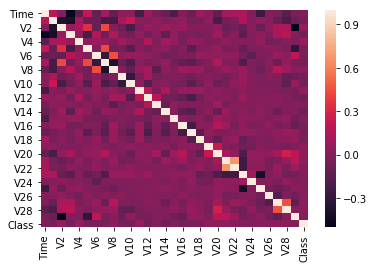

In [15]:
heatmap = sns.heatmap(table.corr(method='spearman'))

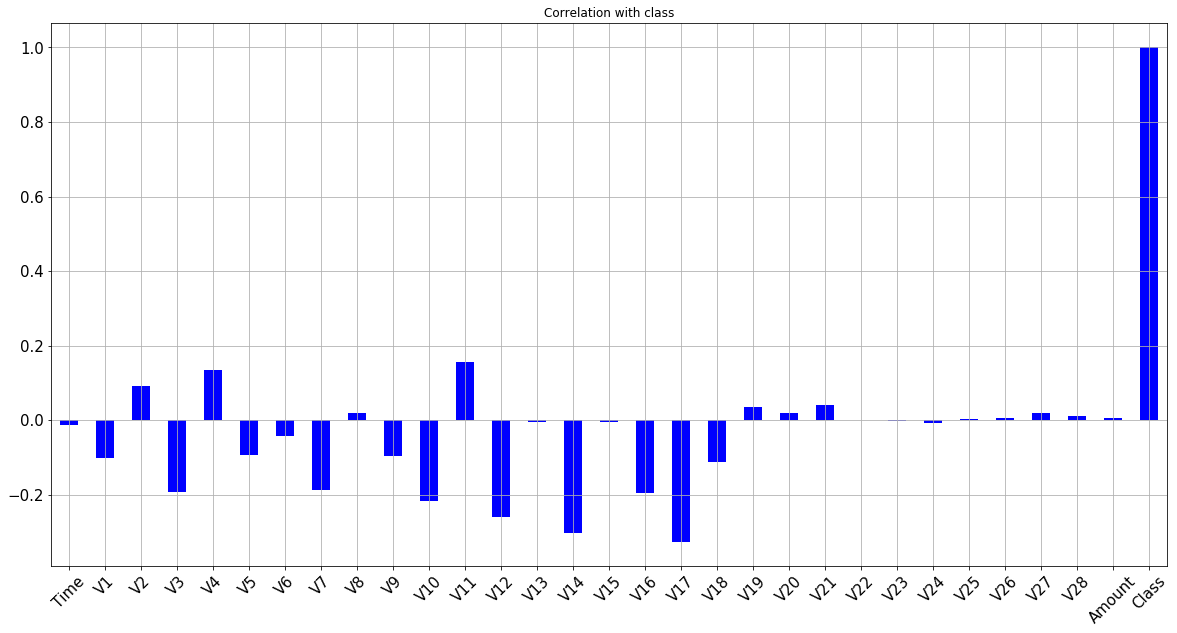

In [16]:
table.corrwith(table.Class).plot.bar(figsize = (20, 10), title = "Correlation with class", fontsize = 15, 
                                     rot = 45, grid = True, color=['blue'])
plt.show()

<a id='Balancing'></a>

# Balancing the classes

Before balancing the classes we need to split the observations into a training set and a testing set. ***This is extremely important!*** We can only balance the classes after we set some observations aside to be used as a test set! Otherwise, the models might use part of the test data during the training, which will lead to overfitting. Let's be smart and avoid that! :)

In [17]:
y = table['Class']
X = table.drop(columns=['Class'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

The data was split in train and test sets maintaining the original rate of frauds to non-frauds observations in each set by using 'stratify=y' in the function train_test_split.

We are going to test three types of resampling methods: [random undersampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler), [random oversampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler) and [Synthetic Minority Over-sampling (SMOTE)](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE). The image below depicts how undersampling and oversampling works and it is very intuitive to understand. SMOTE is similar to oversampling but instead of copying the same original points randomly, the algorithm creates new points close to the original ones.

![](https://github.com/alexandrebvd/udacity-capstone-project-credit-card-fraud-prediction/blob/master/Images/resampling.png?raw=true)

[Image Source](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

<a id='rus'></a>

## Random undersampling

In [19]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42, replacement=False)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

Checking If classes are balanced:

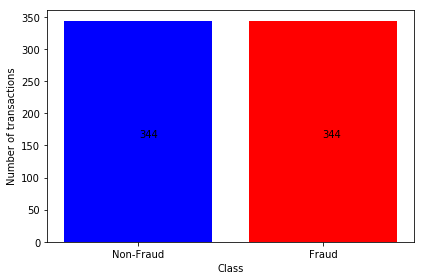

In [20]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_rus)[0], Counter(y_rus)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_rus)[0]), (0.25, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_rus)[1]), (0.75, 0.45), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [21]:
assert Counter(y_rus)[1] == Counter(y_train)[1] #Checking if they have the same number of fraud cases

<a id='ros'></a>

## Random oversampling

In [22]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

Checking If classes are balanced:

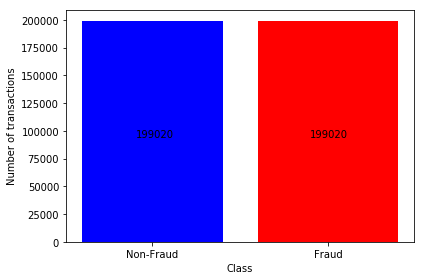

In [23]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_ros)[0], Counter(y_ros)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_ros)[0]), (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_ros)[1]), (0.70, 0.45), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [24]:
assert Counter(y_ros)[0] == Counter(y_train)[0] #Checking if they have the same number of non-fraud cases

<a id='smote'></a>

## Synthetic Minority Over-sampling (SMOTE)

A quick explanation of how SMOTE works: it consists of synthesizing elements for the minority class using the existing ones. It randomly chooses a point from the minority class and computes the k-nearest neighbors (default = 5) for this point. The synthetic points are added between the chosen point and its neighbors by choosing a factor between 0 and 1 to multiply the distance. This process can be seen below.

![](https://github.com/alexandrebvd/udacity-capstone-project-credit-card-fraud-prediction/blob/master/Images/smote.png?raw=true)

[Image Source](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

In [25]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

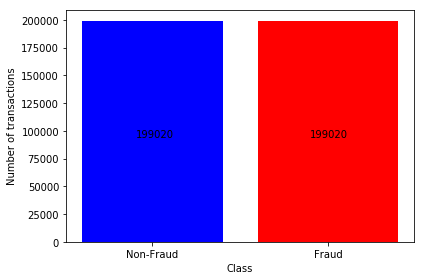

In [26]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_smote)[0], Counter(y_smote)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_smote)[0]), (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_smote)[1]), (0.70, 0.45), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [27]:
assert Counter(y_smote)[0] == Counter(y_train)[0] #Checking if they have the same number of non-fraud cases

<a id='rosxsmote'></a>

### Checking the difference between random oversampling and SMOTE

Because the dataset has many features and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA). But before using PCA, it is recommended to scale the features.

Let's create a function to perform feature scaling because some models need this prior to fitting and we can use it more than one time.

In [28]:
def feature_scaling(X, X_test=X_test):
    std_scale = StandardScaler().fit(X)
    X_std = std_scale.transform(X)
    X_test_std = std_scale.transform(X_test)
    return X_std, X_test_std

Transforming all the sets using different types of sampling:

In [29]:
X_rus_std, X_test_rus_std = feature_scaling(X_rus)
X_ros_std, X_test_ros_std = feature_scaling(X_ros)
X_smote_std, X_test_smote_std = feature_scaling(X_smote)

In [30]:
pca = PCA(n_components=2)
X_ros_pca = pca.fit_transform(X_ros_std)
X_smote_pca = pca.fit_transform(X_smote_std)

Creating a function to visualize the data distribution after the PCA.

In [31]:
def plot_2d_space(X, y, label='Classes'):
    '''Plots the data points in a 2D scatterplot.'''
    colors = ['blue', 'red']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
    plt.title(label)
    plt.legend(loc='best')
    plt.show()

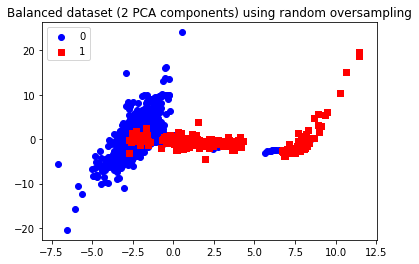

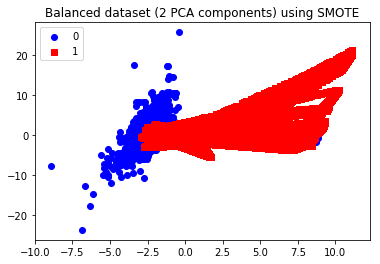

In [32]:
plot_2d_space(X_ros_pca, y_ros, 'Balanced dataset (2 PCA components) using random oversampling')
plot_2d_space(X_smote_pca, y_smote, 'Balanced dataset (2 PCA components) using SMOTE')

Now we can clearly see that new the observations tagged as 1 (fraudulent transactions) are present in different coordinates on the graphs above. This is the SMOTE algorithm works.

Also, by applying the PCA we can visualize the data in 2D and now we can see that the patterns for fraud and non-fraud transactions are distinct and each class has its own cluster.

<a id='metrics'></a>

# Metrics

Usually accuracy is the first metric that comes to mind when someone is assessing a model performance. However, we must be careful. The data in this case is highly unbalanced, so accuracy is not a good metric at all. If we created a model that always classifies a transaction as non-fraudulent, we would have an astonishing accuracy of 99.83%! So, what is the solution? We should use other metrics to consider a model as good or bad.

The metrics to be used will be the [Area Under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) (also called AUC), and the [recall and precision](https://en.wikipedia.org/wiki/Precision_and_recall) scores obtained from the confusion matrix.

The ROC curve is a plot with the true positive rate on the y-axis and false positive rate on the x-axis. The true positive rate answers the question "When the actual classification is positive, how often does the classifier predict positive?" and the false positive rate answers the question "When the actual classification is negative, how often does the classifier incorrectly predict positive?"

The AUC shows how good the classifier is in separating the classes. The closer to 1, the better is the classifier.

Precision answers the question "what proportion of positive identifications was actually correct?" and recall answers "what proportion of actual positives was identified correctly?"

With these 3 metrics the we can to tell whether the model performance is good or poor.

<a id='models'></a>

# Models and Results

The models to be used are shown below. There are also functions to plot the confusion matrix and the ROC curve for the models.

In [33]:
classifiers = []

classifiers.append(('Logistic Regression', LogisticRegression(random_state=42)))
classifiers.append(('Naive Bayes', GaussianNB()))
classifiers.append(('KNN', KNeighborsClassifier()))
#classifiers.append(('SVM', SVC(random_state=42, probability=True))) #This one takes a very long time to run!
classifiers.append(('Decision Tree', DecisionTreeClassifier(random_state=42)))
classifiers.append(('Random Forest', RandomForestClassifier(random_state=42)))

#Ensemble classifier - All classifiers have the same weight
eclf = VotingClassifier(estimators=classifiers, voting='soft', weights=np.ones(len(classifiers)))

The ensemble model used here is a [soft voting classifier](http://www.datajango.com/heterogeneous-ensemble-learning-hard-voting-soft-voting/) which puts the same weight to all individual classifiers' class probabilities. It was already proven in many competitions that classifiers that combine predictions from more than one single classifier can achieve a better performance.

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def plot_CM_and_ROC_curve(classifier, X_train, y_train, X_test, y_test):
    '''Plots the ROC curve and the confusion matrix, and calculates AUC, recall and precision.'''
    
    name = classifier[0]
    classifier = classifier[1]

    mean_fpr = np.linspace(0, 1, 100)
    class_names = ['Non-Fraud', 'Fraud']
    confusion_matrix_total = [[0, 0], [0, 0]]
    
    #Obtain probabilities for each class
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=1, color='b', label='ROC (AUC = %0.7f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - model: ' + name)
    plt.legend(loc="lower right")
    plt.show()
    
    #Store the confusion matrix result to plot a table later
    y_pred=classifier.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_total += cnf_matrix
    
    #Print precision and recall
    tn, fp = confusion_matrix_total.tolist()[0]
    fn, tp = confusion_matrix_total.tolist()[1]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print('Accuracy = {:2.2f}%'.format(accuracy*100))
    print('Precision = {:2.2f}%'.format(precision*100))
    print('Recall = {:2.2f}%'.format(recall*100))
    
    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(confusion_matrix_total, classes=class_names, title='Confusion matrix - model: ' + name)
    plt.show()

<a id='models-rus'></a>

## Results using random undersampling

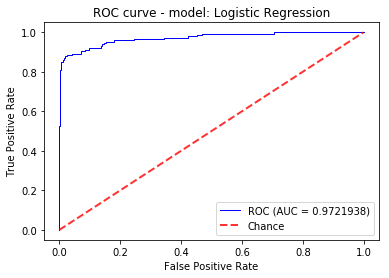

Accuracy = 98.23%
Precision = 7.94%
Recall = 87.16%


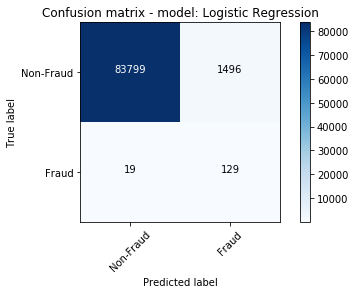

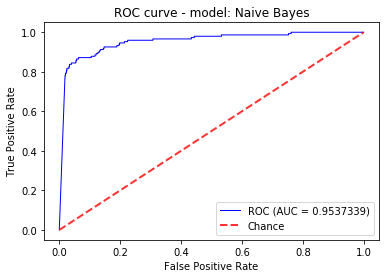

Accuracy = 96.55%
Precision = 4.07%
Recall = 83.78%


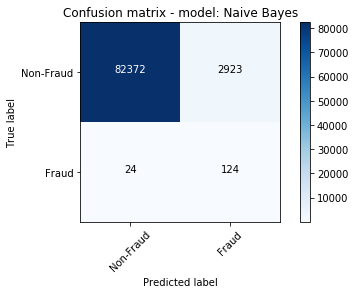

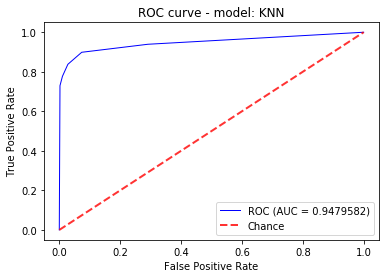

Accuracy = 97.16%
Precision = 4.90%
Recall = 83.78%


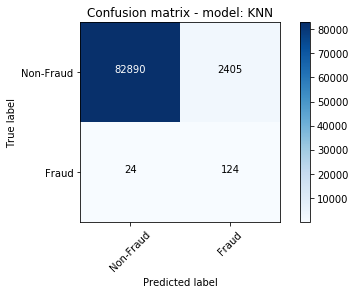

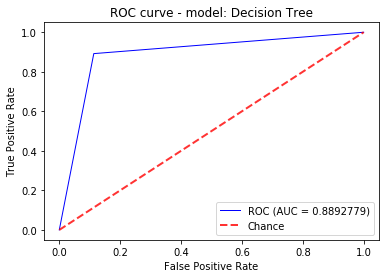

Accuracy = 88.67%
Precision = 1.35%
Recall = 89.19%


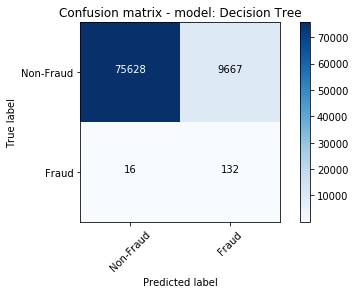

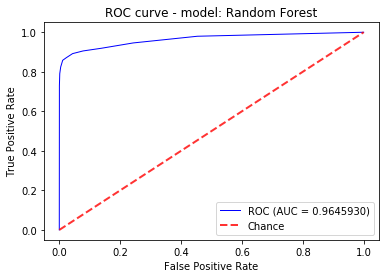

Accuracy = 97.64%
Precision = 6.07%
Recall = 87.16%


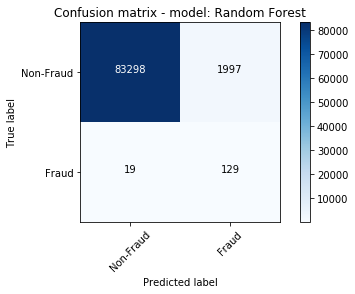

In [36]:
for clf in classifiers:
    plot_CM_and_ROC_curve(clf, X_rus_std, y_rus, X_test_rus_std, y_test)

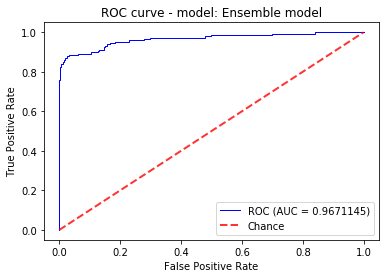

Accuracy = 98.09%
Precision = 7.36%
Recall = 86.49%


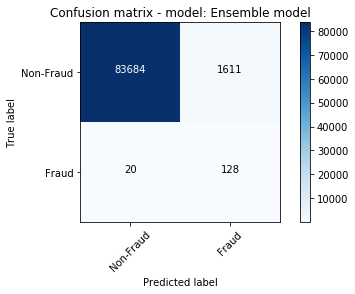

In [37]:
plot_CM_and_ROC_curve(('Ensemble model', eclf), X_rus_std, y_rus, X_test_rus_std, y_test)

<a id='models-ros'></a>

## Results using oversampling

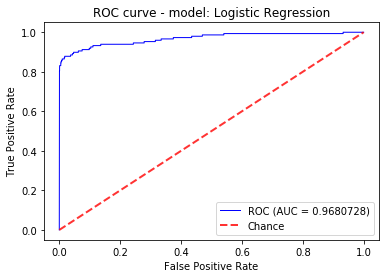

Accuracy = 97.84%
Precision = 6.65%
Recall = 87.84%


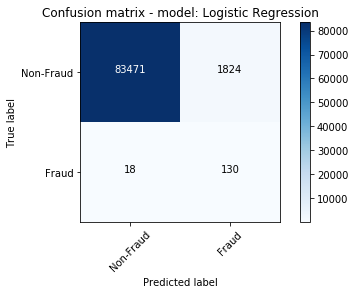

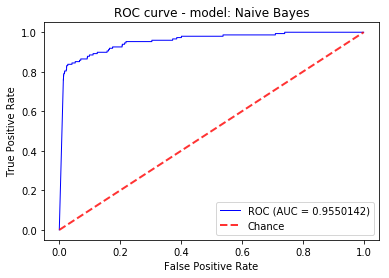

Accuracy = 97.41%
Precision = 5.32%
Recall = 83.11%


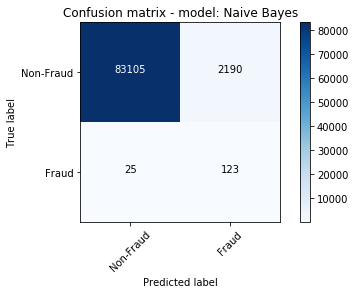

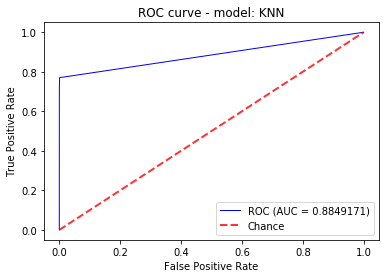

Accuracy = 99.90%
Precision = 68.55%
Recall = 73.65%


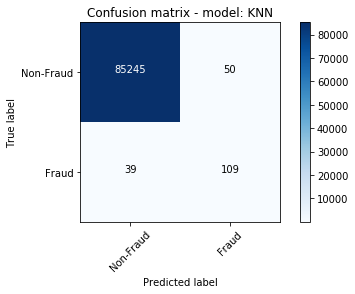

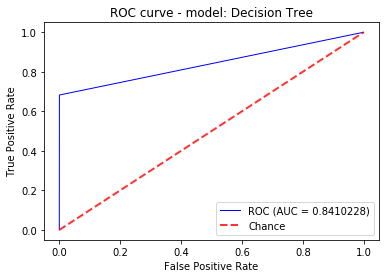

Accuracy = 99.91%
Precision = 75.37%
Recall = 68.24%


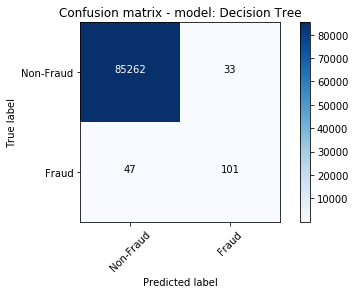

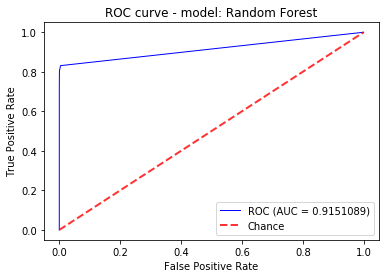

Accuracy = 99.95%
Precision = 97.25%
Recall = 71.62%


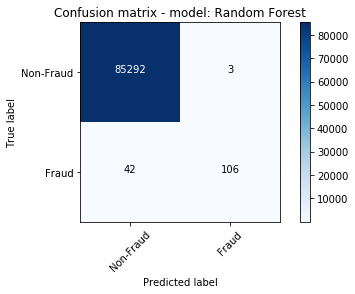

In [38]:
for clf in classifiers:
    plot_CM_and_ROC_curve(clf, X_ros_std, y_ros, X_test_ros_std, y_test)

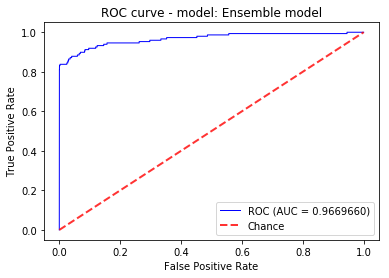

Accuracy = 99.94%
Precision = 85.19%
Recall = 77.70%


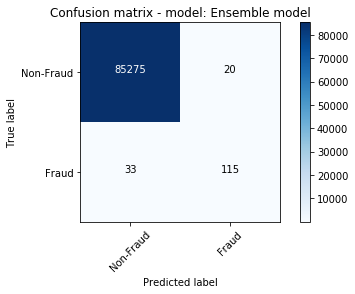

In [39]:
plot_CM_and_ROC_curve(('Ensemble model', eclf), X_ros_std, y_ros, X_test_ros_std, y_test)

<a id='models-smote'></a>

## Results using SMOTE

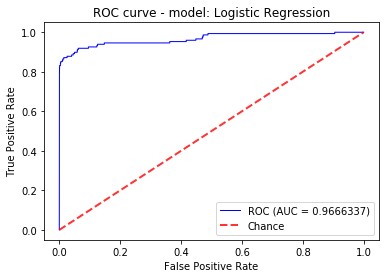

Accuracy = 99.14%
Precision = 14.95%
Recall = 85.14%


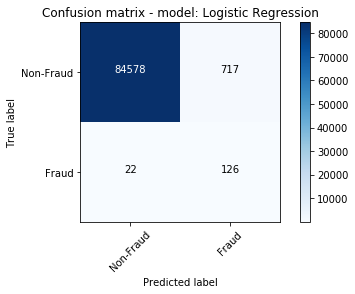

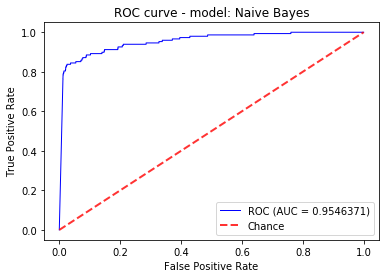

Accuracy = 97.69%
Precision = 5.91%
Recall = 82.43%


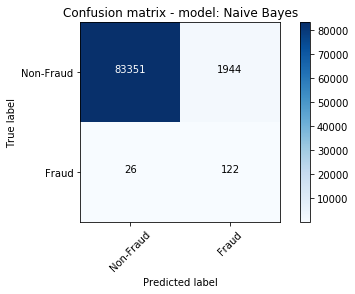

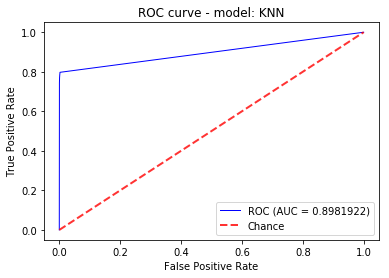

Accuracy = 99.82%
Precision = 48.13%
Recall = 78.38%


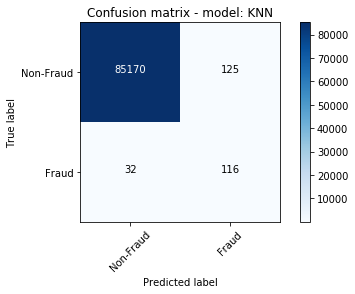

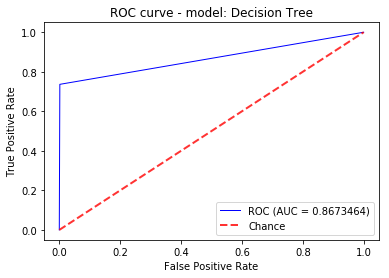

Accuracy = 99.78%
Precision = 41.60%
Recall = 73.65%


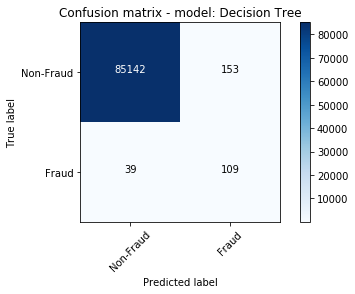

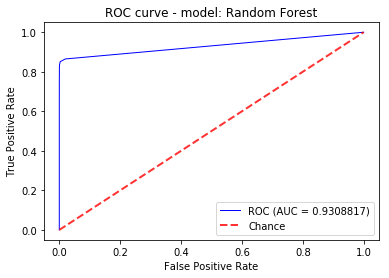

Accuracy = 99.94%
Precision = 84.06%
Recall = 78.38%


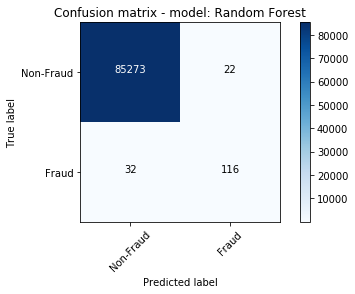

In [40]:
for clf in classifiers:
    plot_CM_and_ROC_curve(clf, X_smote_std, y_smote, X_test_smote_std, y_test)

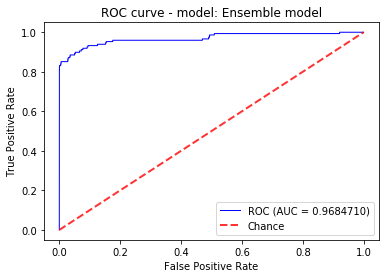

Accuracy = 99.91%
Precision = 72.02%
Recall = 81.76%


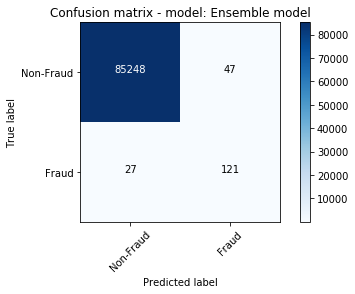

In [41]:
plot_CM_and_ROC_curve(('Ensemble model', eclf), X_smote_std, y_smote, X_test_smote_std, y_test)

<a id='conclusions'></a>

# Conclusions

When we used random undersampling the best model was a simple logistic regression with AUC = 0.9722, recall = 87.16% and precision = 7.94%. The number of false negatives, the worst possible classification regarding frauds, for the logistic regression was 19 out of 148 cases present in the test set. However, we can notice that the ensemble model (a soft voting combination of all simple models with the same weights) was the second best in this case with AUC = 0.9671 and 20 false negative cases, only 1 more than the logistic regression. We can also notice that in all models the number of false positives was pretty high. The best result was with logistic regression (1496 false positive cases). It's good to remember that when we use undersampling method, a lot of information is lost due to discarding part of the observations. Then, it was already expected a not very good result.

With the random oversampling method, we can verify the true power of ensemble models. Our ensemble model combined the best part of the simple models and could get a very high AUC (0.967), high precision (85.19%) and high recall (77.7%). Looking at the confusion matrix we can see the cases for false negative and false positive as 33 and 20, respectively. The logistic regression was the model with the lowest number of false negatives (only 18) and the random forest was the model with the lowest number of false positives (an astonishing result of only 3!). So, if we try to tweak the weights for each model in the ensemble model, we can achieve an even better result.

The analysis for SMOTE method is very similar to the random oversampling method. Again, we can see that the ensemble model could get the best parts of all simple models, resulting in a good performance. Once again, tweaking the weights for each simple model might be a way to enhance the result.

An interesting result is that in all cases of resampling, the highest AUC score among the simple models was using logistic regression. In my opinion, binary classification problems should have at least this model as a benchmark when the objective is to maximize the AUC.